## Connection to RDB

In [11]:
# http://pandas.pydata.org/pandas-docs/version/0.18.1/index.html
import rethinkdb as r
import aclib
import pandas as pd, numpy as np

# http://rethinkdb.com/api
rdb = r.connect(host='127.0.0.1', db='hdh')
print('Bases = %s' % str(r.db_list().run(rdb)))
rdb.use('yanc')

Bases = ['hdh', 'rethinkdb', 'test', 'yanc']


## Ajout de feeds

In [100]:
# r.table('feeds').delete().run(rdb)
#r.table('feeds').insert({'name':'courrier international' , 'url':'http://www.courrierinternational.com/feed/all/rss.xml'}).run(rdb)
#r.table('feeds').insert({'name':'BFM les experts' , 'url':'http://podcast.bfmbusiness.com/channel78/BFMchannel78.xml'}).run(rdb)
#r.table('feeds').insert({'name':'Les crises' , 'url':'http://feeds.feedburner.com/les-crises-fr'}).run(rdb)
liste_feeds = r.table('feeds')['id'].run(rdb)

r.table('users').insert({'id':'aure', 'feeds':liste_feeds}, conflict='replace').run(rdb)
list(r.table('users').run(rdb))

[{'feeds': ['672d5914-8f82-496f-97fb-035eb699c876',
   '921566a8-292b-4dbf-a850-396c58735ed5',
   '45159b9f-27af-4090-8439-ecd5f58b3c79'],
  'id': 'aure'}]

In [106]:
r.table('articles_users').get('311e6193ff780a0f9494516fda99b5233cd4efebd').has_fields('aure').run(rdb)

TypeError: 'NoneType' object is not iterable

In [115]:
import time
from datetime import timedelta
tmpDate = time.gmtime()
datetime.fromtimestamp(time.mktime(tmpDate))




tmpDate2 = datetime.fromtimestamp(time.mktime(tmpDate)) - timedelta(days=13)
tmpDate3 = tmpDate2 - timedelta(hours=3)
tmpNow = datetime.utcnow()
timed = tmpNow - tmpDate3
timed.days

13

In [127]:
(datetime.utcnow() - datetime.fromtimestamp(time.mktime(tmpDate))).days

-1

In [130]:
(datetime.fromtimestamp(time.mktime(tmpDate)) - datetime.utcnow()).days

0

In [129]:
datetime.fromtimestamp(time.mktime(tmpDate))

datetime.datetime(2016, 10, 10, 20, 39, 39)

In [92]:
r.table('users').filter()

{'feeds': ['672d5914-8f82-496f-97fb-035eb699c876',
  '921566a8-292b-4dbf-a850-396c58735ed5']}

In [90]:
r.table('feeds').pluck('id', 'name', 'url').run(rdb)

<rethinkdb.net.DefaultCursor object at 0x7f9855eb7e48 (done streaming):
 [{'url': 'http://podcast.bfmbusiness.com/channel78/BFMchannel78.xml', 'name': 'BFM les experts', 'id': '672d5914-8f82-496f-97fb-035eb699c876'}, {'url': 'http://www.courrierinternational.com/feed/all/rss.xml', 'name': 'courrier international', 'id': '921566a8-292b-4dbf-a850-396c58735ed5'}]>

In [96]:
r.table('articles_users').has_fields('aure').filter(lambda row : row['aure']['status'].ge(0)).count().run(rdb)

79

## Query : rowcount of tables

In [6]:
#-- Query RDB de rowcount de tables dans un DataFrame (format un peu special renvoye par RDB)
# tables_par_row = r.table_list().map(lambda val:[val,r.table(val).count()]).run(rdb) # [['tableX', count], ['tblY', count]]
#-- Query RDB de rowcount de tables dans un DataFrame (format en model list of dict, comme du json)
tables_par_row = r.table_list().map(lambda val: {'tablename':val, 'nbdocs':r.table(val).count()}).run(rdb) # [{'table': 'nom_table', 'count': 11},
df_table_counts = pd.DataFrame(tables_par_row, columns=['tablename', 'nbdocs'])
df_table_counts.set_index(keys='tablename', drop=False, append=False, inplace=True, verify_integrity=True)
#print(tables_par_row, "\n", df_table_counts.nbdocs) # df_table_counts # df.head()

### Graph avec Seaborn

Populating the interactive namespace from numpy and matplotlib


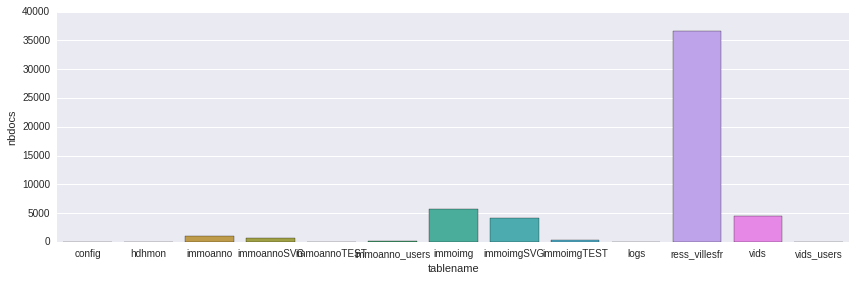

In [7]:
# Graph avec le default matplotlib : df_table_counts.plot(kind='bar')
# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html#seaborn.factorplot
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
sns.factorplot(data=df_table_counts, x='tablename', y='nbdocs', kind="bar", aspect=3.0, order=list(df_table_counts.tablename))

In [44]:
r.table('immoanno').filter(r.row['ts_lastfetched'].ge(r.iso8601('2016-09-01T00:00:00-02:00'))).count().run(rdb)

484

## Query : Nb de docs par ville

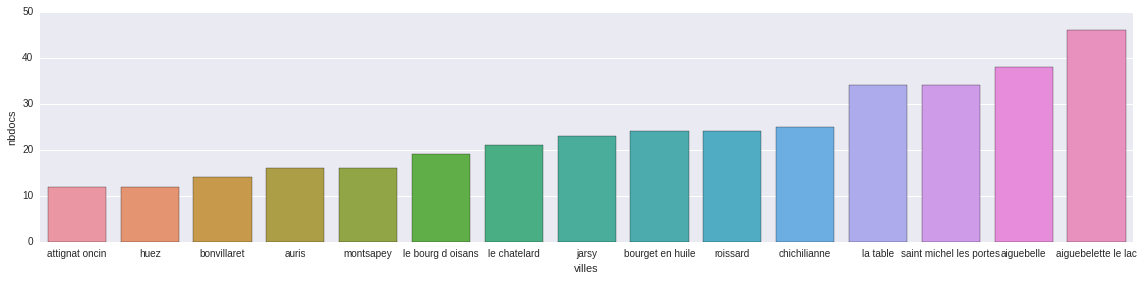

In [45]:
distri_ville = r.table('immoanno').filter(r.row['ts_lastfetched'].ge(r.iso8601('2016-09-01T00:00:00-02:00'))).group('localite_stz').count().run(rdb) 
distri_ville_df = pd.DataFrame(columns=['villes', 'nbdocs'], data={'villes': list(distri_ville.keys()), 'nbdocs': list(distri_ville.values())})
#distri_ville_df.head()
df_to_show = distri_ville_df.sort_values(by='nbdocs', ascending=True, inplace=False, kind='quicksort', na_position='last')
df_to_show = df_to_show[-15:]
sns.factorplot(data=df_to_show, x='villes', y='nbdocs', kind="bar", aspect=4.0, order=list(df_to_show.villes))

## Query : Nb de docs par jour sur un field timestamp

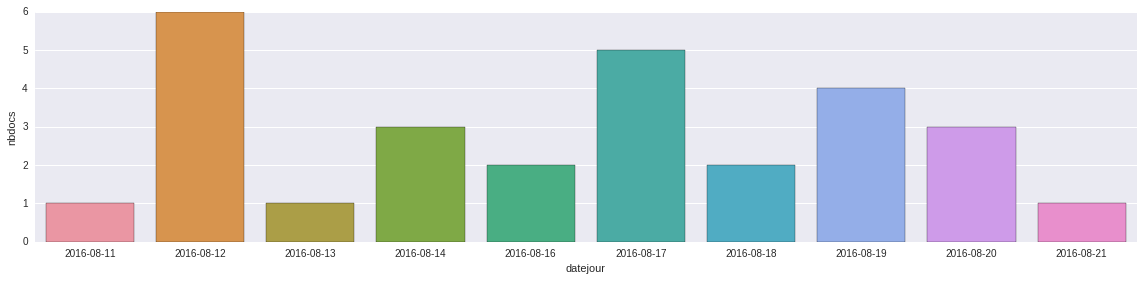

In [348]:
#list(r.table('immoanno').get_field('ts_updated').map(lambda val: val.to_iso8601().slice(0,10)).group('ts_updated').count().limit(10).run(rdb))

distri_date = r.table('immoanno').map(lambda val: val.merge(r.object('ts_updated_group', val['ts_updated'].to_iso8601().slice(0,10)))).group('ts_updated_group').count().run(rdb) 
#distri_date_df = pd.DataFrame(index=distri_date.keys(), columns=['nbdocs'], data=list(distri_date.values()))

distri_date_df = pd.DataFrame(columns=['datejour', 'nbdocs'], data={'datejour': list(distri_date.keys()), 'nbdocs': list(distri_date.values())})
df_to_show = distri_date_df.sort_values(by='datejour', ascending=True, inplace=False, kind='quicksort', na_position='last')
df_to_show = df_to_show[-10:]
sns.factorplot(data=df_to_show, x='datejour', y='nbdocs', kind="bar", aspect=4.0, order=list(df_to_show.datejour))
#distri_date_df

## Deplacer des items dont un champ fait partie d'une liste

In [ ]:
from aclib.func4strings import Func4strings as f4s
liste_villes_exclure = ['aix les bains', '73100', 'auris', '38142', 'bernin', '38190', 'chambery', '38000', 'grenoble', '73000', 'charvieu chavagneux', 'huez', '38750', 'bourg d oisans', 'livet et gavet', 'montmelian']

objs = list(r.table('immoanno').run(rdb))
nb_anno_discarded = 0
for obj in objs :
    if f4s.strMatchAny(liste_villes_exclure, obj['localite_stz']) or f4s.strMatchAny(liste_villes_exclure, obj['codepostal']):
        r.table('immoannoDiscarded').insert(obj).run(rdb)
        r.table('immoanno').get(obj['id']).delete().run(rdb)
        nb_anno_discarded += 1
nb_anno_discarded

## Query : recup sur config

In [353]:
print(r.table('config')['id'].distinct().run(rdb))

['check.requirements', 'deamon.monitor.rdb', 'deamon.scan.vifiles', 'fetch.imm.lbc', 'fetch.imm.sudi', 'fetch.imm.zil', 'fetcher.homwiz', 'ops4app', 'websrv.immo', 'websrv.static', 'websrv.vid']


In [357]:
list(r.table('config').filter(r.row['id'].match('fetch.imm.sudi')).run(rdb))

[{'id': 'fetch.imm.zil',
  'period.in.days': 2,
  'rdb.table.annonces': 'immoanno',
  'rdb.table.images': 'immoimg',
  'urls': {'bauges.73630': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Doucy-en-Bauges%20(73630),Jarsy%20(73630),La%20Compôte%20(73630),Le%20Châtelard%20(73630).htm',
   'belledonne.73110': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Bourget-en-Huile%20(73110),La%20Table%20(73110),Le%20Pontet%20(73110).htm',
   'belledonne.73220': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Aiguebelle%20(73220),Bonvillaret%20(73220),Montsapey%20(73220).htm',
   'ecrins.38520': 'http://zilek.fr/immobilier/city/1/max_p-600000~radius-10~trans_type-sale~property_type-house~sort-date/Villard-Reymond%20(38520).htm',
   'monteynard.38350': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Cognet%20(38350

In [358]:
r.table('config').get('fetch.imm.sudi').delete().run(rdb)

{'deleted': 1,
 'errors': 0,
 'inserted': 0,
 'replaced': 0,
 'skipped': 0,
 'unchanged': 0}

In [16]:
list(r.table('ress_villesfr').filter(lambda row : r.expr(['38','73']).contains(row['departement'])).pluck('codepostal', 'nom_stz').limit(5).run(rdb))

[{'codepostal': '38260', 'nom_stz': 'bossieu'},
 {'codepostal': '38890', 'nom_stz': 'vasselin'},
 {'codepostal': '38280', 'nom_stz': 'janneyrias'},
 {'codepostal': '73260', 'nom_stz': 'saint oyen'},
 {'codepostal': '38450', 'nom_stz': 'miribel lanchatre'}]

In [13]:
r.expr(['38','78']).contains('38').run(rdb)

True

In [9]:
l = list(r.table('ress_villesfr').filter(['38','73].contains(r.row['departement'].eq('38')).pluck('codepostal', 'nom_stz').run(rdb))
len(l)

0

In [5]:
c = r.table('immoanno').limit(1).run(rdb)
list(c)

[{'classeenergie': '',
  'codepostal': '38350',
  'description': "Maison proche du lac de Monteynard. A proximité de MARCIEU, à environ 800 m du lac, sur une parcelle de 1705 m², cette maison à rénover se compose de 3 chambres, un bureau ou débarras et un garage dans un petit hameau sur les pentes du lac de Monteynard à 20 minutes de la Mure. Idéalement exposé, plein sud, elle bénéficie d'une magnifique vue sur le lac et les montagnes du Vercors.",
  'description_stz': 'maison proche du lac de monteynard a proximite de marcieu a environ 800 m du lac sur une parcelle de 1705 m2 cette maison a renover se compose de 3 chambres un bureau ou debarras et un garage dans un petit hameau sur les pentes du lac de monteynard a 20 minutes de la mure idealement expose plein sud elle beneficie d une magnifique vue sur le lac et les montagnes du vercors',
  'ges': '',
  'history': {},
  'id': 'http://www.immo-isere.com/fr/la-mure/maison-de-campagne,3009078.html?type=0&nbpieces=0&localisation=marcieu&

## Query docs from a table

In [257]:
# Dump d'une table RDB dans un DataFrame
df_t_config = pd.DataFrame(list(r.table('config').run(rdb)))
print(sorted(list(df_t_config['id'])))
df_t_config.head()

['check.requirements', 'deamon.monitor.rdb', 'deamon.scan.vifiles', 'fetch.imm.lbc', 'fetch.imm.sudi', 'fetch.imm.zil', 'fetcher.homwiz', 'ops4app', 'websrv.immo', 'websrv.static', 'websrv.vid']


,bases.to.monitor,fich_ignore,fich_soustit,fich_vid,homwiz.url.allsensors,homwiz.url.contactsensor.history.prefixe,homwiz.url.contactsensor.history.suffixe,id,idb.database.sensors,idb.ip,...,rdb.table.annonces,rdb.table.images,rdb.table.phot,rdb.table.vidfiles,rdb.table.vids,rdb.table.vids.users,reps,table_cfg_in_rdb,table_logs_in_rdb,urls
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fetch.imm.zil,NaN,NaN,...,immoanno,immoimg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'monteynard.38650': 'http://zilek.fr/immobili...
1,NaN,"[jpg, jpeg, png, pdf, mht, ac3, mp3, rar]","[srt, idx, sub, txt, srr, sup, ass]","[mkv, ts, avi, mp4, mpg, flv, webm, wmv, divx,...",NaN,NaN,NaN,deamon.scan.vifiles,NaN,NaN,...,NaN,NaN,NaN,vids,NaN,NaN,"{'vi2': '\\192.168.75.96\vi2\', 'vi1new': '\\1...",NaN,NaN,NaN
2,hdh;,NaN,NaN,NaN,NaN,NaN,NaN,deamon.monitor.rdb,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fetch.imm.lbc,NaN,NaN,...,immoanno,immoimg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'monteynard.38650': 'http://www.leboncoin.fr/...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,check.requirements,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
